# CS445 Project

# Classification of hand-drawn letters using Convolutional Neural Networks

**by Sanchit Talavdekar**

## Introduction

In this project, I have used Convolutional Neural Networks (CNN) to classify hand-drawn letters. Taking inspiration from the MNIST data set which only had 10 classes, I wanted to train my CNN model on a more challenging dataset which would have even more classes. The dataset that I found for my project is of hand-drawn lowercase letters. This is the Stanford OCR dataset where each row represents a lowercase letter and has the following values:
1.	id: each letter is assigned a unique integer id
2.	letter: a-z
3.	next_id: id for next letter in the word, -1 if last letter
4.	word_id: each word is assigned a unique integer id (not used)
5.	position: position of letter in the word (not used)
6.	fold: 0-9 -- cross-validation fold
7.	p_i_j: 0/1 -- value of pixel in row i, column j

The dataset is available here: http://ai.stanford.edu/~btaskar/ocr/

There are 52152 letters to classify among 26 classes.

Resources used from the class include:

1) Function for generating stratified partitions of the dataset adapted from Lecture 10

2) Code for CNN2D class for training the models adapted from assignment A5

3) Function for constructing confusion matrix adapted from assignment A4

Results showed that the best training model gave around 85% accuracy on the testing dataset.

To understand the dataset more better let us take a look at it.

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

In [2]:
t = pd.read_csv("letter.names", delim_whitespace=True, header = None)
data = pd.read_csv('letter.data', delim_whitespace=True, header=None, names = list(t[0]))

In [3]:
data

,id,letter,next_id,word_id,position,fold,p_0_0,p_0_1,p_0_2,p_0_3,...,p_14_6,p_14_7,p_15_0,p_15_1,p_15_2,p_15_3,p_15_4,p_15_5,p_15_6,p_15_7
0,1,o,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,m,3,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,m,4,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,a,5,1,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,n,6,1,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52147,52148,n,52149,6877,10,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52148,52149,t,52150,6877,11,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52149,52150,i,52151,6877,12,9,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
52150,52151,a,52152,6877,13,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let us consider the first row. Wait! We have pixel values in this row so let us consider those instead.

In [4]:
image1 = data.iloc[0:1,6:].values
# By observing column names we can conclude that there are 16 rows and 8 columns of an image
image1 = image1.reshape(16, 8)
image1

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 1, 0],
       [1, 1, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

Alright. Let's use matplotlib to make an image display.

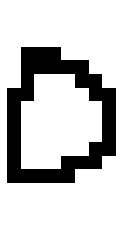

In [5]:
plt.imshow(-image1, cmap='gray');
plt.axis('off');

Looks like an 'o'. Let's look at the class label.

In [6]:
data.iloc[0:1,1:2].values

array([['o']], dtype=object)

That is correct. Now let's take a look at first 100 rows of the dataset.

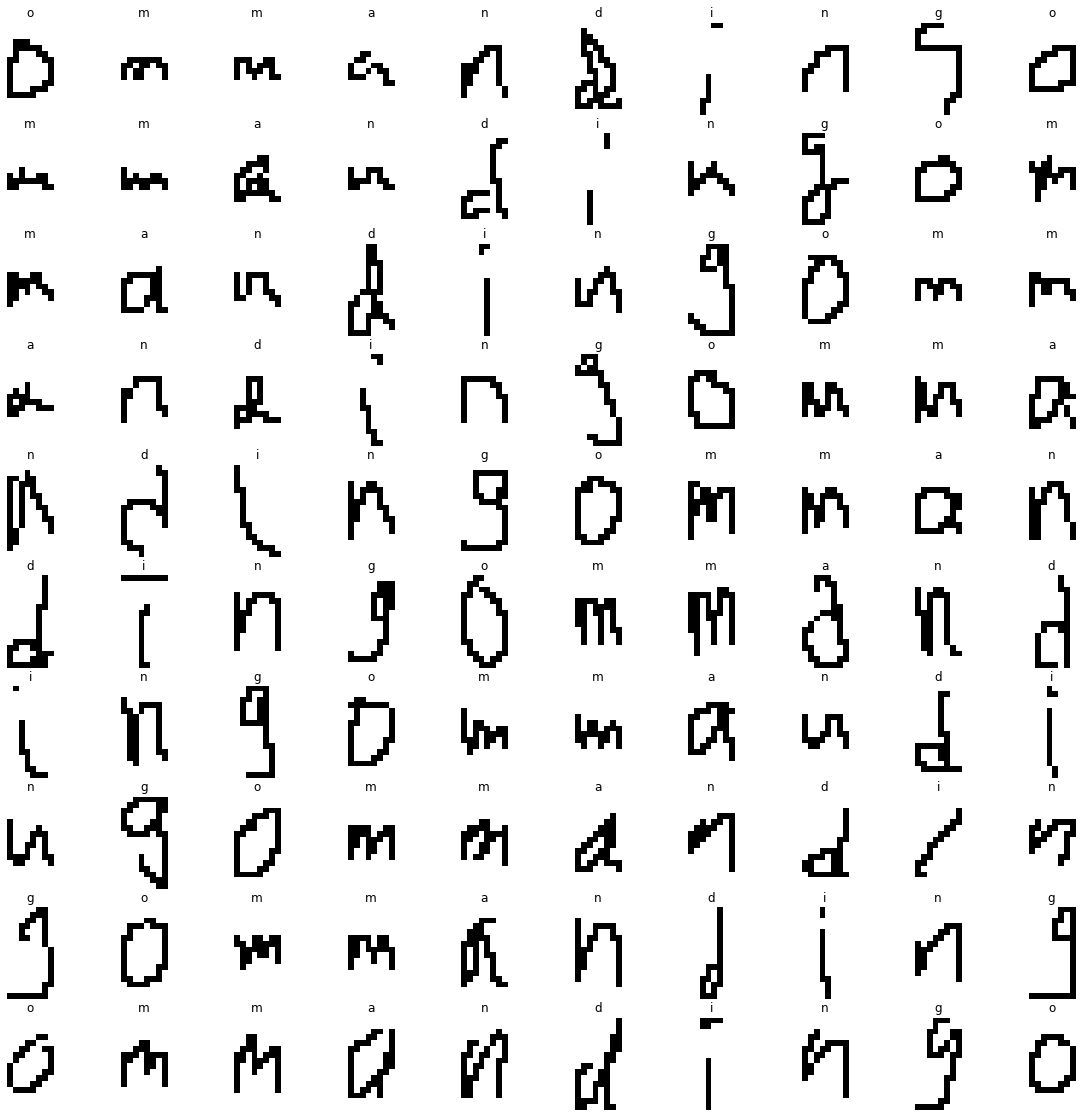

In [7]:
plt.figure(figsize=(20, 20))
for i in range(100):
    a = data.iloc[i:i+1,6:].values
    b= data.iloc[:,1:2].values
    plt.subplot(10, 10, i + 1)
    plt.imshow(-a.reshape(16, 8), cmap='gray')
    plt.title(b[i,0])
    plt.axis('off');

Alright! So, the goal of this project is to train a CNN model to classify the letters in this dataset.

## Setup

Each row in this dataset represents a lowercase letter. The pixel values in the row represent the image of the letter. This will be input to our model. Each row also has the label of that letter. This will be output of our model. We now make a input sample matrix containing the pixel values of the image and a output target matrix that will contain the class labels.  

In [8]:
X = data.iloc[0:,6:].values
T = data.iloc[0:,1:2].values

In [9]:
X.shape,T.shape

((52152, 128), (52152, 1))

Each image of our dataset is of size 16x8. In order to prevent matrix multiplication errors, it would be more convenient if the height and width are the same values. So, we add four columns at the start and four columns at the end of an image to make the size of the image 16x16. The values of these additional columns will be 0. We need to make a new input matrix which will have the updated image pixel values. Let us call this new input matrix `newX`. It is derived by modifying the original input matrix `X`. The following is the code for constructing `newX`:    

In [10]:
newX = [] #Initialize newX as a blank list
for orig in X: # Take each row of the original matrix X
    blank = [0]*4
    newImage = []
    for row in orig.reshape(16, 8): #Take each row of the reshaped image of size 16*8
        newImage.append(blank+list(row)+blank) #Add four elements of value 0 at the start and at the end 
    newX.append(np.array(newImage).flatten())  #Flatten the image and append to the list newX  
    
newX = np.array(newX) #Covert the list newX into a numpy array

Let us check the images in the new input sample `newX`

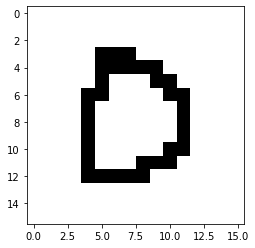

In [11]:
plt.imshow(-(newX[0].reshape(16, 16)), cmap='gray');

Great!! Now we will not get any matrix multiplication errors.

In [12]:
newX.shape,T.shape

((52152, 256), (52152, 1))

We partition our data into train, validation and test sets. Here, we use stratified partitioning to make each fold have approximately the same proportion of samples from each class.

In [13]:
# This code is adapted from Lecture 10. It is slightly modified to exclude the 'no validation set' condition.
def generate_stratified_partitions(X, T, n_folds, shuffle=True):
    
    def rows_in_fold(folds, k):
        all_rows = []
        for c, rows in folds.items():
            class_rows, starts, stops = rows
            all_rows += class_rows[starts[k]:stops[k]].tolist()
        return all_rows

    def rows_in_folds(folds, ks):
        all_rows = []
        for k in ks:
            all_rows += rows_in_fold(folds, k)
        return all_rows

    row_indices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(row_indices)
    folds = {}
    classes = np.unique(T)
    for c in classes:
        class_indices = row_indices[np.where(T[row_indices, :] == c)[0]]
        n_in_class = len(class_indices)
        n_each = int(n_in_class / n_folds)
        starts = np.arange(0, n_each * n_folds, n_each)
        stops = starts + n_each
        stops[-1] = n_in_class
        folds[c] = [class_indices, starts, stops]

    for test_fold in range(n_folds):
        for validate_fold in range(n_folds):
            if test_fold == validate_fold:
                continue
            train_folds = np.setdiff1d(range(n_folds), [test_fold, validate_fold])
            rows = rows_in_fold(folds, test_fold)
            Xtest = X[rows, :]
            Ttest = T[rows, :]
            rows = rows_in_fold(folds, validate_fold)
            Xvalidate = X[rows, :]
            Tvalidate = T[rows, :]
            rows = rows_in_folds(folds, train_folds)
            Xtrain = X[rows, :]
            Ttrain = T[rows, :]
            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

In [14]:
Xtrain,  Ttrain,  Xval, Tval, Xtest,  Ttest = next(generate_stratified_partitions(newX, T, 5))
Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((31316, 256), (31316, 1), (10418, 256), (10418, 1), (10418, 256), (10418, 1))

Let us check if our `generate_stratified_partitions` function worked correctly. The following code checks the sample distribution ratio in the train, validation and test sets for a randomly generated sample.

In [15]:
uniques = np.unique(Ttrain)
lisst = [Ttrain, Tval,  Ttest]
lucky_letter = np.random.choice(uniques)
print(f"Let us consider the letter '{lucky_letter}'\n")
a = []
for l in lisst:
    m = np.count_nonzero(l==lucky_letter)
    a.append(m)
print(f'Ttrain has {a[0]} samples\nTval has {a[1]} samples\nTtest has {a[2]} samples\n')
b = min(a)
print(f'The sample distribution ratio is\nTtrain : Tval : Ttest = {a[0]/b:.1f} : {a[1]/b:.1f} : {a[2]/b:.1f}')

Let us consider the letter 'j'

Ttrain has 115 samples
Tval has 37 samples
Ttest has 37 samples

The sample distribution ratio is
Ttrain : Tval : Ttest = 3.1 : 1.0 : 1.0


Great!! Our samples are distributed correctly. 

We now define our 2D CNN class which we will be using for training our model. 

In [21]:
#This code is adapted from assignment A5
class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

The code below makes our system to perform the pytorch computations on the GPU if the system has a cuda enabled GPU.

In [17]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Would you like to run on the GPU? (y or n): y
Running on cuda:0


We will require a function that tells us the accuracy of the trained model. So, lets write a code for that.

In [18]:
def accuracy(y,t):
    perc_correct = 100 * np.mean(y == t)
    return perc_correct

We require a similar function for our experiments for calculating and printing the accuracy of training, testing and validation sets.

In [19]:
def printstuff(Xtrain,Ttrain,Xtest,Ttest,Xval,Tval):
    
    print(f'Training took {elapsed_time} seconds.')
    Classes_train, _train = cnnet.use(Xtrain)
    train_perc_correct = accuracy(Classes_train,Ttrain)
    print(f'Train accuracy in percent correct: {train_perc_correct:.2f}')
    
    Classes_test, _test = cnnet.use(Xtest)
    test_perc_correct = accuracy(Classes_test,Ttest)
    print(f'Test accuracy in percent correct: {test_perc_correct:.2f}')
    
    Classes_val, _test = cnnet.use(Xval)
    val_perc_correct = accuracy(Classes_val,Tval)
    print(f'Test accuracy in percent correct: {test_perc_correct:.2f}')
    print('\n')
    
    return train_perc_correct,test_perc_correct,val_perc_correct

We will require column names for the `pandas` dataframe. 

In [20]:
names = ('Epochs','Batch size','Learning Rate','Hiddens per convolutional layer', 'Patch size per convolutional layer', 'Stride per convolutional layer', 'Hiddens per fully-connected layer', 'Train percent correct', 'Test percent correct','Validate percent correct', 'Training time (seconds)')

We will also require confusion matrix to study our predictions.

In [22]:
#This code is adapted from assignment A4
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pd.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

We reshape Xtest, Xval, Xtest because convolutional nets in pytorch require reshaping the input matrices.

In [23]:
Xtrain = Xtrain.reshape(-1, 1, 16, 16)
Xval = Xval.reshape(-1, 1, 16, 16)
Xtest = Xtest.reshape(-1, 1, 16, 16)

Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((31316, 1, 16, 16),
 (31316, 1),
 (10418, 1, 16, 16),
 (10418, 1),
 (10418, 1, 16, 16),
 (10418, 1))

Okay. Now that we have defined all the functions and classes that we need, let us run a test to check if the model training works.

adam: Epoch 2 Loss 3.205
adam: Epoch 4 Loss 2.970
adam: Epoch 6 Loss 2.853
adam: Epoch 8 Loss 2.804
adam: Epoch 10 Loss 2.778
adam: Epoch 12 Loss 2.760
adam: Epoch 14 Loss 2.746
adam: Epoch 16 Loss 2.736
adam: Epoch 18 Loss 2.748
adam: Epoch 20 Loss 2.718


Text(0.5, 1.0, 'Hand-drawn letters')

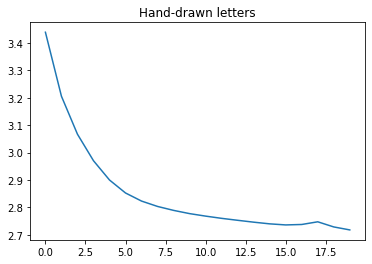

In [21]:
n_hiddens_per_conv_layer = [10, 5]
patch_size_per_conv_layer = [3, 2]
stride_per_conv_layer=[1, 4]
n_hiddens_per_fc_layer = [1]

cnnet = CNN2D(16 * 16, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('Hand-drawn letters')

Perfect. Now we can run some experiments.

## Experiments

Experiments will be performed using different architectures and various hyperparameter values. We also use `time` to better understand the duration of training the models. The goal is to get the highest test accuracy.

To have a methodical approach, instead of running experiments with multiple random parameters, let us only consider multiple values of a single parameter at a time.

**Experiment 1: Different network architectures for fully-connected layer**

So, this first batch of experiments uses different architectures for fully connected layer. Rest of the parameters are constant.

In [29]:
results1 = []
n_epochs = 20
batch_size = 500
learning_rate = 0.01
n_hiddens_per_conv_layer = [10,20]
patch_size_per_conv_layer = [5,2]
stride_per_conv_layer=[3,1]
n_hiddens_per_fc_layer = [ [], [10], [10,10], [10,10,10], [5,5,5], [25,20], [100], [200], [80], [70]]

for fc_layer in n_hiddens_per_fc_layer:
    
    print('Fully-connected layer:', fc_layer)
    
    start_time = time.time()
    
    cnnet = CNN2D(16 * 16, n_hiddens_per_conv_layer, fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)
    
    cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
    
    elapsed_time = time.time() - start_time
    
    train_perc_correct,test_perc_correct,val_perc_correct=printstuff(Xtrain,Ttrain,Xtest,Ttest,Xval,Tval)
    
    experiment = [n_epochs,batch_size,learning_rate,n_hiddens_per_conv_layer, patch_size_per_conv_layer, stride_per_conv_layer, fc_layer, train_perc_correct, test_perc_correct, val_perc_correct, elapsed_time]
    results1.append(experiment)

Fully-connected layer: []
adam: Epoch 2 Loss 1.440
adam: Epoch 4 Loss 1.133
adam: Epoch 6 Loss 0.996
adam: Epoch 8 Loss 0.935
adam: Epoch 10 Loss 0.877
adam: Epoch 12 Loss 0.823
adam: Epoch 14 Loss 0.793
adam: Epoch 16 Loss 0.756
adam: Epoch 18 Loss 0.730
adam: Epoch 20 Loss 0.724
Training took 2.6941168308258057 seconds.
Train accuracy in percent correct: 82.76
Test accuracy in percent correct: 80.13
Test accuracy in percent correct: 80.13


Fully-connected layer: [10]
adam: Epoch 2 Loss 2.253
adam: Epoch 4 Loss 1.701
adam: Epoch 6 Loss 1.423
adam: Epoch 8 Loss 1.251
adam: Epoch 10 Loss 1.130
adam: Epoch 12 Loss 1.044
adam: Epoch 14 Loss 0.985
adam: Epoch 16 Loss 0.934
adam: Epoch 18 Loss 0.897
adam: Epoch 20 Loss 0.871
Training took 3.316105842590332 seconds.
Train accuracy in percent correct: 76.99
Test accuracy in percent correct: 74.48
Test accuracy in percent correct: 74.48


Fully-connected layer: [10, 10]
adam: Epoch 2 Loss 2.392
adam: Epoch 4 Loss 1.895
adam: Epoch 6 Loss 1.62

In [30]:
EXP1 = pd.DataFrame(results1, columns=names)
EXP1.sort_values('Test percent correct')

,Epochs,Batch size,Learning Rate,Hiddens per convolutional layer,Patch size per convolutional layer,Stride per convolutional layer,Hiddens per fully-connected layer,Train percent correct,Test percent correct,Validate percent correct,Training time (seconds)
4,20,500,0.01,"[10, 20]","[5, 2]","[3, 1]","[5, 5, 5]",59.921446,58.600499,58.552505,4.184252
3,20,500,0.01,"[10, 20]","[5, 2]","[3, 1]","[10, 10, 10]",72.908417,70.886926,71.174890,3.957353
2,20,500,0.01,"[10, 20]","[5, 2]","[3, 1]","[10, 10]",74.683868,72.211557,72.192359,3.948643
1,20,500,0.01,"[10, 20]","[5, 2]","[3, 1]",[10],76.989398,74.476867,75.062392,3.316106
5,20,500,0.01,"[10, 20]","[5, 2]","[3, 1]","[25, 20]",81.616426,78.508351,78.076406,3.331401
0,20,500,0.01,"[10, 20]","[5, 2]","[3, 1]",[],82.762805,80.130543,80.216932,2.694117
7,20,500,0.01,"[10, 20]","[5, 2]","[3, 1]",[200],87.361093,82.376656,82.559032,2.100662
9,20,500,0.01,"[10, 20]","[5, 2]","[3, 1]",[70],86.045472,82.376656,82.415051,2.178256
8,20,500,0.01,"[10, 20]","[5, 2]","[3, 1]",[80],86.846979,82.885391,82.597428,2.150919
6,20,500,0.01,"[10, 20]","[5, 2]","[3, 1]",[100],87.664453,83.077366,83.211749,2.712307


From the above table we can see that, when all the other parameters are constant and only the network architecture of fully-connected layer is changed, a single layer gives higher accuracy on test set than two or three layers. Further, we can see that, using 100 neurons in this single layer gives highest accuracy on the test set compared to other single layer neuron values. Using 200 neurons might be overfitting the model and hence we get less accuracy while using linear layer gives even less value for accuracy on the test set. So, we go forward with keeping the network architecture of the fully-connected layer as [100].

**Experiment 2: Different network architectures for convolutional layer**

Now, we change only the network architecture for the convolutional layer. Rest of the parameters are constant. For better understanding the patch sizes and strides are kept as 2 respectively.

In [31]:
results2 = []
n_epochs = 20
batch_size = 500
learning_rate = 0.01
n_hiddens_per_conv_layer = [[10],[10,10],[10,10,10],[50,50,50],[30,20],[100],[200],[500]]
patch_size_per_conv_layer = [[2],[2,2],[2,2,2],[2,2,2],[2,2],[2],[2],[2]]
stride_per_conv_layer=[[2],[2,2],[2,2,2],[2,2,2],[2,2],[2],[2],[2]]
n_hiddens_per_fc_layer = [100]

for i in range(8):
    
    print('Hiddens per convolutional layer:', n_hiddens_per_conv_layer[i])
    print('Patch size per convolutional layer:', patch_size_per_conv_layer[i])
    print('Stride per convolutional layer:', stride_per_conv_layer[i])
    
    start_time = time.time()
    
    cnnet = CNN2D(16 * 16, n_hiddens_per_conv_layer[i], n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer[i], stride_per_conv_layer[i], device=device)
    
    cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
    
    elapsed_time = time.time() - start_time
    
    train_perc_correct,test_perc_correct,val_perc_correct=printstuff(Xtrain,Ttrain,Xtest,Ttest,Xval,Tval)
    
    experiment = [n_epochs,batch_size,learning_rate,n_hiddens_per_conv_layer[i], patch_size_per_conv_layer[i], stride_per_conv_layer[i], n_hiddens_per_fc_layer, train_perc_correct, test_perc_correct, val_perc_correct, elapsed_time]
    results2.append(experiment)

Hiddens per convolutional layer: [10]
Patch size per convolutional layer: [2]
Stride per convolutional layer: [2]
adam: Epoch 2 Loss 2.161
adam: Epoch 4 Loss 1.121
adam: Epoch 6 Loss 0.843
adam: Epoch 8 Loss 0.794
adam: Epoch 10 Loss 0.667
adam: Epoch 12 Loss 0.572
adam: Epoch 14 Loss 0.532
adam: Epoch 16 Loss 0.493
adam: Epoch 18 Loss 0.446
adam: Epoch 20 Loss 0.412
Training took 2.7145917415618896 seconds.
Train accuracy in percent correct: 90.18
Test accuracy in percent correct: 84.50
Test accuracy in percent correct: 84.50


Hiddens per convolutional layer: [10, 10]
Patch size per convolutional layer: [2, 2]
Stride per convolutional layer: [2, 2]
adam: Epoch 2 Loss 4.262
adam: Epoch 4 Loss 3.984
adam: Epoch 6 Loss 2.856
adam: Epoch 8 Loss 1.728
adam: Epoch 10 Loss 1.368
adam: Epoch 12 Loss 1.069
adam: Epoch 14 Loss 0.869
adam: Epoch 16 Loss 0.811
adam: Epoch 18 Loss 0.747
adam: Epoch 20 Loss 0.688
Training took 2.3148608207702637 seconds.
Train accuracy in percent correct: 83.07
Te

In [32]:
EXP2 = pd.DataFrame(results2, columns=names)
EXP2.sort_values('Test percent correct')

,Epochs,Batch size,Learning Rate,Hiddens per convolutional layer,Patch size per convolutional layer,Stride per convolutional layer,Hiddens per fully-connected layer,Train percent correct,Test percent correct,Validate percent correct,Training time (seconds)
5,20,500,0.01,[100],[2],[2],[100],9.630860,9.637166,9.637166,1.626569
6,20,500,0.01,[200],[2],[2],[100],9.630860,9.637166,9.637166,2.049143
7,20,500,0.01,[500],[2],[2],[100],9.630860,9.637166,9.637166,3.248592
4,20,500,0.01,"[30, 20]","[2, 2]","[2, 2]",[100],22.799847,23.085045,23.104243,2.077134
3,20,500,0.01,"[50, 50, 50]","[2, 2, 2]","[2, 2, 2]",[100],68.613488,67.949702,68.180073,2.997619
2,20,500,0.01,"[10, 10, 10]","[2, 2, 2]","[2, 2, 2]",[100],77.979308,76.828566,76.617393,2.645544
1,20,500,0.01,"[10, 10]","[2, 2]","[2, 2]",[100],83.066164,81.176809,81.100019,2.314861
0,20,500,0.01,[10],[2],[2],[100],90.180738,84.497984,84.545978,2.714592


From the above table we can see that, when all the other parameters are constant and only the network architecture of convolutional layer is changed, a single layer gives higher accuracy on test set than two or three layers. A very unique observation here is that, if in a single layer the neurons are kept at a very high value like 100 or 200 or 500, we get accuracy value of around 9%, much less than when we use a two or a three layer network architecture for this layer.  So, we go forward with keeping the network architecture of the convolutional layer as [10].

**Experiment 3: Different neurons for a single layer convolutional layer**

Now, we test with different neurons for the single layer convolutional layer. Rest of the parameters are constant.

In [35]:
results3 = []
n_epochs = 20
batch_size = 500
learning_rate = 0.01
n_hiddens_per_conv_layer = [[10],[30],[50],[5],[1],[100],[200],[500]]
patch_size_per_conv_layer = [2]
stride_per_conv_layer=[2]
n_hiddens_per_fc_layer = [100]

for conv_layer in n_hiddens_per_conv_layer:
    
    print('Convolutional layer:', conv_layer)
    
    start_time = time.time()
    
    cnnet = CNN2D(16 * 16, conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)
    
    cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
    
    elapsed_time = time.time() - start_time
    
    train_perc_correct,test_perc_correct,val_perc_correct=printstuff(Xtrain,Ttrain,Xtest,Ttest,Xval,Tval)
    
    experiment = [n_epochs,batch_size,learning_rate,conv_layer, patch_size_per_conv_layer, stride_per_conv_layer, n_hiddens_per_fc_layer, train_perc_correct, test_perc_correct, val_perc_correct, elapsed_time]
    results3.append(experiment)

Convolutional layer: [10]
adam: Epoch 2 Loss 1.633
adam: Epoch 4 Loss 1.077
adam: Epoch 6 Loss 0.761
adam: Epoch 8 Loss 0.662
adam: Epoch 10 Loss 0.623
adam: Epoch 12 Loss 0.520
adam: Epoch 14 Loss 0.470
adam: Epoch 16 Loss 0.439
adam: Epoch 18 Loss 0.409
adam: Epoch 20 Loss 0.382
Training took 3.1370670795440674 seconds.
Train accuracy in percent correct: 91.26
Test accuracy in percent correct: 84.46
Test accuracy in percent correct: 84.46


Convolutional layer: [30]
adam: Epoch 2 Loss 4.124
adam: Epoch 4 Loss 4.159
adam: Epoch 6 Loss 4.166
adam: Epoch 8 Loss 4.169
adam: Epoch 10 Loss 4.171
adam: Epoch 12 Loss 4.172
adam: Epoch 14 Loss 4.173
adam: Epoch 16 Loss 4.173
adam: Epoch 18 Loss 4.174
adam: Epoch 20 Loss 4.174
Training took 2.8583619594573975 seconds.
Train accuracy in percent correct: 9.63
Test accuracy in percent correct: 9.64
Test accuracy in percent correct: 9.64


Convolutional layer: [50]
adam: Epoch 2 Loss 4.120
adam: Epoch 4 Loss 4.158
adam: Epoch 6 Loss 4.165
adam: Ep

In [36]:
EXP3 = pd.DataFrame(results3, columns=names)
EXP3.sort_values('Test percent correct')

,Epochs,Batch size,Learning Rate,Hiddens per convolutional layer,Patch size per convolutional layer,Stride per convolutional layer,Hiddens per fully-connected layer,Train percent correct,Test percent correct,Validate percent correct,Training time (seconds)
1,20,500,0.01,[30],[2],[2],[100],9.630860,9.637166,9.637166,2.858362
2,20,500,0.01,[50],[2],[2],[100],9.630860,9.637166,9.637166,1.659721
5,20,500,0.01,[100],[2],[2],[100],9.630860,9.637166,9.637166,1.645887
6,20,500,0.01,[200],[2],[2],[100],9.630860,9.637166,9.637166,1.755735
7,20,500,0.01,[500],[2],[2],[100],9.630860,9.637166,9.637166,3.249198
4,20,500,0.01,[1],[2],[2],[100],82.580789,80.735266,80.466500,1.830389
0,20,500,0.01,[10],[2],[2],[100],91.260059,84.459589,84.661163,3.137067
3,20,500,0.01,[5],[2],[2],[100],89.583599,84.603571,84.929929,2.351498


As observed in experiment 2, in a single layer convolutional layer, if the neurons are kept at a high value like 30 or 50 or 100 or 200 or 500, we get very less accuracy value of around 9%. Using five neurons gives the highest accuracy for the test set. So, we go forward with keeping the network architecture of the convolutional layer as [5].

**Experiment 4: Different patch sizes for the convolutional layer**

Now, we test with different patch sizes for the convolutional layer. Rest of the parameters are constant.

In [37]:
results4 = []
n_epochs = 20
batch_size = 500
learning_rate = 0.01
n_hiddens_per_conv_layer = [5]
patch_size_per_conv_layer = [[10],[15],[16],[4],[5],[6],[12],[1],[2]]
stride_per_conv_layer=[2]
n_hiddens_per_fc_layer = [100]

for patch in patch_size_per_conv_layer:
    
    print('Patch size:', patch)
    
    start_time = time.time()
    
    cnnet = CNN2D(16 * 16, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch, stride_per_conv_layer, device=device)
    
    cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
    
    elapsed_time = time.time() - start_time
    
    train_perc_correct,test_perc_correct,val_perc_correct=printstuff(Xtrain,Ttrain,Xtest,Ttest,Xval,Tval)
    
    experiment = [n_epochs,batch_size,learning_rate,n_hiddens_per_conv_layer, patch, stride_per_conv_layer, n_hiddens_per_fc_layer, train_perc_correct, test_perc_correct, val_perc_correct, elapsed_time]
    results4.append(experiment)

Patch size: [10]
adam: Epoch 2 Loss 1.417
adam: Epoch 4 Loss 1.108
adam: Epoch 6 Loss 0.857
adam: Epoch 8 Loss 0.788
adam: Epoch 10 Loss 0.702
adam: Epoch 12 Loss 0.664
adam: Epoch 14 Loss 0.614
adam: Epoch 16 Loss 0.589
adam: Epoch 18 Loss 0.552
adam: Epoch 20 Loss 0.532
Training took 1.5657432079315186 seconds.
Train accuracy in percent correct: 87.13
Test accuracy in percent correct: 82.97
Test accuracy in percent correct: 82.97


Patch size: [15]
adam: Epoch 2 Loss 2.090
adam: Epoch 4 Loss 1.751
adam: Epoch 6 Loss 1.682
adam: Epoch 8 Loss 1.664
adam: Epoch 10 Loss 1.605
adam: Epoch 12 Loss 1.585
adam: Epoch 14 Loss 1.558
adam: Epoch 16 Loss 1.528
adam: Epoch 18 Loss 1.505
adam: Epoch 20 Loss 1.485
Training took 1.5895285606384277 seconds.
Train accuracy in percent correct: 61.38
Test accuracy in percent correct: 60.86
Test accuracy in percent correct: 60.86


Patch size: [16]
adam: Epoch 2 Loss 2.006
adam: Epoch 4 Loss 1.652
adam: Epoch 6 Loss 1.575
adam: Epoch 8 Loss 1.557
adam: E

In [38]:
EXP4 = pd.DataFrame(results4, columns=names)
EXP4.sort_values('Test percent correct')

,Epochs,Batch size,Learning Rate,Hiddens per convolutional layer,Patch size per convolutional layer,Stride per convolutional layer,Hiddens per fully-connected layer,Train percent correct,Test percent correct,Validate percent correct,Training time (seconds)
1,20,500,0.01,[5],[15],[2],[100],61.377571,60.856210,60.376272,1.589529
7,20,500,0.01,[5],[1],[2],[100],63.475540,60.904204,59.694759,2.528387
2,20,500,0.01,[5],[16],[2],[100],62.782603,61.864081,61.604915,1.502310
6,20,500,0.01,[5],[12],[2],[100],84.653212,81.196007,81.080822,1.767045
0,20,500,0.01,[5],[10],[2],[100],87.134372,82.971780,83.086965,1.565743
4,20,500,0.01,[5],[5],[2],[100],89.468642,83.547706,83.816471,1.509044
5,20,500,0.01,[5],[6],[2],[100],90.592668,84.229219,84.517182,1.518693
3,20,500,0.01,[5],[4],[2],[100],89.906118,84.478787,84.152428,1.512728
8,20,500,0.01,[5],[2],[2],[100],89.430323,85.016318,84.766750,1.564972


From the above table we can see that, using a large patch size like 12 or 15 or 16 gives comparatively less accuracy values for the test set than using small patch sizes like 2 or 4. The image itself is a 16x16 image. Hence, using larger patch sizes considers the entire image at a time for computing which renders the point of convolution useless. Also, it is observed that using patch size of 1 also gives less accuracy values. The highest accuracy value for test set is observed when the patch size is kept 2. So, we go forward with keeping the patch size of the convolutional layer as [2].

**Experiment 5: Different stride values for the convolutional layer**

Now, we test with different stride values for the convolutional layer. Rest of the parameters are constant.

In [39]:
results5 = []
n_epochs = 20
batch_size = 500
learning_rate = 0.01
n_hiddens_per_conv_layer = [5]
patch_size_per_conv_layer = [2]
stride_per_conv_layer = [[10],[15],[16],[4],[5],[6],[12],[1],[2]]
n_hiddens_per_fc_layer = [100]

for stride in stride_per_conv_layer:
    
    print('Stride:', stride)
    
    start_time = time.time()
    
    cnnet = CNN2D(16 * 16, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride, device=device)
    
    cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
    
    elapsed_time = time.time() - start_time
    
    train_perc_correct,test_perc_correct,val_perc_correct=printstuff(Xtrain,Ttrain,Xtest,Ttest,Xval,Tval)
    
    experiment = [n_epochs,batch_size,learning_rate,n_hiddens_per_conv_layer, patch_size_per_conv_layer, stride, n_hiddens_per_fc_layer, train_perc_correct, test_perc_correct, val_perc_correct, elapsed_time]
    results5.append(experiment)

Stride: [10]
adam: Epoch 2 Loss 2.803
adam: Epoch 4 Loss 2.731
adam: Epoch 6 Loss 2.701
adam: Epoch 8 Loss 2.678
adam: Epoch 10 Loss 2.667
adam: Epoch 12 Loss 2.661
adam: Epoch 14 Loss 2.628
adam: Epoch 16 Loss 2.613
adam: Epoch 18 Loss 2.596
adam: Epoch 20 Loss 2.586
Training took 2.6708035469055176 seconds.
Train accuracy in percent correct: 26.13
Test accuracy in percent correct: 25.90
Test accuracy in percent correct: 25.90


Stride: [15]
adam: Epoch 2 Loss 3.090
adam: Epoch 4 Loss 3.062
adam: Epoch 6 Loss 3.061
adam: Epoch 8 Loss 3.067
adam: Epoch 10 Loss 3.045
adam: Epoch 12 Loss 3.043
adam: Epoch 14 Loss 3.053
adam: Epoch 16 Loss 3.043
adam: Epoch 18 Loss 3.044
adam: Epoch 20 Loss 3.033
Training took 1.6376867294311523 seconds.
Train accuracy in percent correct: 9.63
Test accuracy in percent correct: 9.64
Test accuracy in percent correct: 9.64


Stride: [16]
adam: Epoch 2 Loss 3.086
adam: Epoch 4 Loss 3.058
adam: Epoch 6 Loss 3.052
adam: Epoch 8 Loss 3.055
adam: Epoch 10 Loss 3.

In [40]:
EXP5 = pd.DataFrame(results5, columns=names)
EXP5.sort_values('Test percent correct')

,Epochs,Batch size,Learning Rate,Hiddens per convolutional layer,Patch size per convolutional layer,Stride per convolutional layer,Hiddens per fully-connected layer,Train percent correct,Test percent correct,Validate percent correct,Training time (seconds)
1,20,500,0.01,[5],[2],[15],[100],9.630860,9.637166,9.637166,1.637687
2,20,500,0.01,[5],[2],[16],[100],9.630860,9.637166,9.637166,1.640221
6,20,500,0.01,[5],[2],[12],[100],9.630860,9.637166,9.637166,1.611454
7,20,500,0.01,[5],[2],[1],[100],9.630860,9.637166,9.637166,2.064681
0,20,500,0.01,[5],[2],[10],[100],26.127219,25.897485,26.540603,2.670804
5,20,500,0.01,[5],[2],[6],[100],28.895772,28.047610,28.325974,1.595410
4,20,500,0.01,[5],[2],[5],[100],46.653468,46.467652,45.651757,1.592860
3,20,500,0.01,[5],[2],[4],[100],52.790906,52.207717,51.123056,1.706458
8,20,500,0.01,[5],[2],[2],[100],90.295695,85.429065,85.582645,2.562121


From the above table we can see that, using a stride values like 12 or 15 or 16 gives very less accuracy values of 9% for the test set. Even using stride value of 1 gives low accuracy of 9.63%. The highest accuracy value for test set is observed when the stride value is kept 2. So, we go forward with keeping the stride value of the convolutional layer as [2].

**Experiment 6: Different learning rate values**

Now, we test with different learning rates. Rest of the parameters are constant.

In [41]:
results6 = []
n_epochs = 20
batch_size = 500
learning_rate = [0.1,0.01,0.001,0.03,0.05,0.08, 0.2]
n_hiddens_per_conv_layer = [5]
patch_size_per_conv_layer = [2]
stride_per_conv_layer = [2]
n_hiddens_per_fc_layer = [100]

for lr in learning_rate:
    
    print('Learning Rate:', lr)
    
    start_time = time.time()
    
    cnnet = CNN2D(16 * 16, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)
    
    cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, lr, method='adam')
    
    elapsed_time = time.time() - start_time
    
    train_perc_correct,test_perc_correct,val_perc_correct=printstuff(Xtrain,Ttrain,Xtest,Ttest,Xval,Tval)
    
    experiment = [n_epochs,batch_size,lr,n_hiddens_per_conv_layer, patch_size_per_conv_layer, stride_per_conv_layer, n_hiddens_per_fc_layer, train_perc_correct, test_perc_correct, val_perc_correct, elapsed_time]
    results6.append(experiment)

Learning Rate: 0.1
adam: Epoch 2 Loss 17.710
adam: Epoch 4 Loss 17.605
adam: Epoch 6 Loss 17.837
adam: Epoch 8 Loss 18.435
adam: Epoch 10 Loss 17.735
adam: Epoch 12 Loss 18.078
adam: Epoch 14 Loss 18.329
adam: Epoch 16 Loss 17.544
adam: Epoch 18 Loss 18.083
adam: Epoch 20 Loss 18.447
Training took 3.083775043487549 seconds.
Train accuracy in percent correct: 9.42
Test accuracy in percent correct: 9.43
Test accuracy in percent correct: 9.43


Learning Rate: 0.01
adam: Epoch 2 Loss 1.684
adam: Epoch 4 Loss 1.045
adam: Epoch 6 Loss 0.840
adam: Epoch 8 Loss 0.760
adam: Epoch 10 Loss 0.645
adam: Epoch 12 Loss 0.600
adam: Epoch 14 Loss 0.536
adam: Epoch 16 Loss 0.487
adam: Epoch 18 Loss 0.460
adam: Epoch 20 Loss 0.415
Training took 1.804875373840332 seconds.
Train accuracy in percent correct: 90.26
Test accuracy in percent correct: 85.46
Test accuracy in percent correct: 85.46


Learning Rate: 0.001
adam: Epoch 2 Loss 2.352
adam: Epoch 4 Loss 1.618
adam: Epoch 6 Loss 1.301
adam: Epoch 8 Loss

In [42]:
EXP6 = pd.DataFrame(results6, columns=names)
EXP6.sort_values('Test percent correct')

,Epochs,Batch size,Learning Rate,Hiddens per convolutional layer,Patch size per convolutional layer,Stride per convolutional layer,Hiddens per fully-connected layer,Train percent correct,Test percent correct,Validate percent correct,Training time (seconds)
4,20,500,0.050,[5],[2],[2],[100],4.093754,4.098675,4.098675,1.629705
6,20,500,0.200,[5],[2],[2],[100],5.125176,5.125744,5.125744,1.943521
0,20,500,0.100,[5],[2],[2],[100],9.416911,9.425993,9.425993,3.083775
5,20,500,0.080,[5],[2],[2],[100],75.233108,74.217700,73.190632,1.626254
2,20,500,0.001,[5],[2],[2],[100],79.518457,78.325974,78.229987,1.642683
3,20,500,0.030,[5],[2],[2],[100],89.321752,82.866193,83.269342,1.631749
1,20,500,0.010,[5],[2],[2],[100],90.263763,85.457861,85.429065,1.804875


From the above table we can see that, for learning rate values 0.2, 0.1 and 0.05, accuracy values for the test set are way too less. This can be because these learning rates are high and so, the value obtained from the function might be jumping either left or right of the minimum value. Using 0.001 as learning rate might require more number of epochs to train the model. The highest accuracy value for test set is observed when the learning rate is kept 0.01. So, we go forward with keeping the patch size of the convolutional layer as 0.01.

**Experiment 7: Different batch sizes**

Now, we test with different batch sizes. Rest of the parameters are constant.

In [44]:
results7 = []
n_epochs = 20
batch_size = [10,50,100,500,600,450,550,1000]
learning_rate = 0.01
n_hiddens_per_conv_layer = [5]
patch_size_per_conv_layer = [2]
stride_per_conv_layer = [2]
n_hiddens_per_fc_layer = [100]

for bs in batch_size:
    
    print('Batch size:', bs)
    
    start_time = time.time()
    
    cnnet = CNN2D(16 * 16, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)
    
    cnnet.train(Xtrain, Ttrain, bs, n_epochs, learning_rate, method='adam')
    
    elapsed_time = time.time() - start_time
    
    train_perc_correct,test_perc_correct,val_perc_correct=printstuff(Xtrain,Ttrain,Xtest,Ttest,Xval,Tval)
    
    experiment = [n_epochs,bs,learning_rate,n_hiddens_per_conv_layer, patch_size_per_conv_layer, stride_per_conv_layer, n_hiddens_per_fc_layer, train_perc_correct, test_perc_correct, val_perc_correct, elapsed_time]
    results7.append(experiment)

Batch size: 10
adam: Epoch 2 Loss 2.389
adam: Epoch 4 Loss 2.316
adam: Epoch 6 Loss 1.626
adam: Epoch 8 Loss 1.712
adam: Epoch 10 Loss 1.587
adam: Epoch 12 Loss 1.806
adam: Epoch 14 Loss 1.689
adam: Epoch 16 Loss 1.808
adam: Epoch 18 Loss 1.826
adam: Epoch 20 Loss 1.842
Training took 149.6403148174286 seconds.
Train accuracy in percent correct: 14.88
Test accuracy in percent correct: 14.93
Test accuracy in percent correct: 14.93


Batch size: 50
adam: Epoch 2 Loss 2.633
adam: Epoch 4 Loss 2.430
adam: Epoch 6 Loss 2.272
adam: Epoch 8 Loss 2.325
adam: Epoch 10 Loss 2.156
adam: Epoch 12 Loss 1.865
adam: Epoch 14 Loss 1.962
adam: Epoch 16 Loss 1.901
adam: Epoch 18 Loss 1.719
adam: Epoch 20 Loss 1.787
Training took 21.348029851913452 seconds.
Train accuracy in percent correct: 53.44
Test accuracy in percent correct: 52.73
Test accuracy in percent correct: 52.73


Batch size: 100
adam: Epoch 2 Loss 3.847
adam: Epoch 4 Loss 2.490
adam: Epoch 6 Loss 1.688
adam: Epoch 8 Loss 1.671
adam: Epoch 1

In [45]:
EXP7 = pd.DataFrame(results7, columns=names)
EXP7.sort_values('Test percent correct')

,Epochs,Batch size,Learning Rate,Hiddens per convolutional layer,Patch size per convolutional layer,Stride per convolutional layer,Hiddens per fully-connected layer,Train percent correct,Test percent correct,Validate percent correct,Training time (seconds)
0,20,10,0.01,[5],[2],[2],[100],14.877379,14.926089,14.570935,149.640315
1,20,50,0.01,[5],[2],[2],[100],53.442330,52.726051,52.927625,21.348030
2,20,100,0.01,[5],[2],[2],[100],76.906374,74.620849,73.920138,7.555972
7,20,1000,0.01,[5],[2],[2],[100],88.245625,84.891534,84.306009,0.849507
6,20,550,0.01,[5],[2],[2],[100],89.583599,84.901133,84.584373,1.738140
5,20,450,0.01,[5],[2],[2],[100],89.213182,84.939528,84.689960,1.747148
4,20,600,0.01,[5],[2],[2],[100],89.615532,85.131503,85.477059,1.335915
3,20,500,0.01,[5],[2],[2],[100],90.576702,85.141102,85.208293,1.601591


From the above table we can see that, keeping the batch size 10 takes training time and also gives less accuracy values for the test set. Keeping batch size 1000 gives the fastest training time while giving high accuracy values. Increasing batch size increases the graphic memory usage and therefore require more GPU memory for computation. Batch size from 500 to 1000 give very high and very similar accuracy values for the test set. The highest accuracy value is observed when the batch size is kept 500. So, we go forward with keeping the batch size as 500.

**Experiment 8: Different epoch values**

Finally, we test with different values for number of epochs. Rest of the parameters are constant.

In [47]:
results8 = []
n_epochs = [10,20,50,70,100,500,1000]
batch_size = 500
learning_rate = 0.01
n_hiddens_per_conv_layer = [5]
patch_size_per_conv_layer = [2]
stride_per_conv_layer = [2]
n_hiddens_per_fc_layer = [100]

for ep in n_epochs:
    
    print('Epochs:', ep)
    
    start_time = time.time()
    
    cnnet = CNN2D(16 * 16, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)
    
    cnnet.train(Xtrain, Ttrain, batch_size, ep, learning_rate, method='adam')
    
    elapsed_time = time.time() - start_time
    
    train_perc_correct,test_perc_correct,val_perc_correct=printstuff(Xtrain,Ttrain,Xtest,Ttest,Xval,Tval)
    
    experiment = [ep,batch_size,learning_rate,n_hiddens_per_conv_layer, patch_size_per_conv_layer, stride_per_conv_layer, n_hiddens_per_fc_layer, train_perc_correct, test_perc_correct, val_perc_correct, elapsed_time]
    results8.append(experiment)

Epochs: 10
adam: Epoch 1 Loss 4.175
adam: Epoch 2 Loss 1.646
adam: Epoch 3 Loss 1.311
adam: Epoch 4 Loss 1.056
adam: Epoch 5 Loss 0.881
adam: Epoch 6 Loss 0.805
adam: Epoch 7 Loss 0.764
adam: Epoch 8 Loss 0.782
adam: Epoch 9 Loss 0.718
adam: Epoch 10 Loss 0.642
Training took 1.0426199436187744 seconds.
Train accuracy in percent correct: 85.25
Test accuracy in percent correct: 83.11
Test accuracy in percent correct: 83.11


Epochs: 20
adam: Epoch 2 Loss 1.589
adam: Epoch 4 Loss 1.033
adam: Epoch 6 Loss 0.828
adam: Epoch 8 Loss 0.739
adam: Epoch 10 Loss 0.633
adam: Epoch 12 Loss 0.577
adam: Epoch 14 Loss 0.521
adam: Epoch 16 Loss 0.474
adam: Epoch 18 Loss 0.441
adam: Epoch 20 Loss 0.409
Training took 1.7783966064453125 seconds.
Train accuracy in percent correct: 90.47
Test accuracy in percent correct: 85.79
Test accuracy in percent correct: 85.79


Epochs: 50
adam: Epoch 5 Loss 0.902
adam: Epoch 10 Loss 0.644
adam: Epoch 15 Loss 0.529
adam: Epoch 20 Loss 0.423
adam: Epoch 25 Loss 0.361
a

In [48]:
EXP8 = pd.DataFrame(results8, columns=names)
EXP8.sort_values('Test percent correct')

,Epochs,Batch size,Learning Rate,Hiddens per convolutional layer,Patch size per convolutional layer,Stride per convolutional layer,Hiddens per fully-connected layer,Train percent correct,Test percent correct,Validate percent correct,Training time (seconds)
0,10,500,0.01,[5],[2],[2],[100],85.253545,83.106162,82.751008,1.042620
6,1000,500,0.01,[5],[2],[2],[100],98.965385,83.106162,82.799002,158.431651
5,500,500,0.01,[5],[2],[2],[100],98.923873,83.432521,83.509311,69.359119
4,100,500,0.01,[5],[2],[2],[100],97.866905,83.970052,84.593972,15.161430
3,70,500,0.01,[5],[2],[2],[100],95.647592,84.795546,85.006719,6.528735
2,50,500,0.01,[5],[2],[2],[100],95.864734,85.553849,85.985794,7.629286
1,20,500,0.01,[5],[2],[2],[100],90.468131,85.793818,85.659436,1.778397


From the above table we can see that, as the number of epochs is increased it takes longer time to train the model. The accuracy values for all the different number of epochs tested here are very close to each other. The model trains the fastest when number of epochs is kept 10 but might require more epochs to converge at a low RMSE value to give high accuracy on test data. We can see that the accuracy value is the highest when number of epochs is kept 20 while also training in significantly lower time. So, we go forward with keeping the number of epochs as 20.

Alright! Now that the experiments are done let us train our model with the best parameter values which are as follows:

Number of epochs: 20

Batch size: 500

Learning rate: 0.01

Convolutional layer network architecture: [5]

Patch size for convolutional layer: [2]

Stride for convolutional layer: [2]

Fully-connected layer network architecture: [100]

adam: Epoch 2 Loss 1.609
adam: Epoch 4 Loss 1.075
adam: Epoch 6 Loss 0.858
adam: Epoch 8 Loss 0.783
adam: Epoch 10 Loss 0.670
adam: Epoch 12 Loss 0.616
adam: Epoch 14 Loss 0.564
adam: Epoch 16 Loss 0.515
adam: Epoch 18 Loss 0.478
adam: Epoch 20 Loss 0.443


Text(0.5, 1.0, 'Hand-drawn letters')

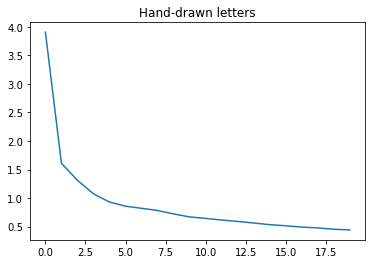

In [24]:
n_epochs = 20
batch_size = 500
learning_rate = 0.01

n_hiddens_per_conv_layer = [5]
patch_size_per_conv_layer = [2]
stride_per_conv_layer=[2]
n_hiddens_per_fc_layer = [100]

cnnet = CNN2D(16 * 16, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('Hand-drawn letters')

Perfect. Now, let us check the accuracy for test data with this trained model.

In [25]:
Y_classes, Y_probs = cnnet.use(Xtest)
accuracy(Y_classes,Ttest)

85.94739873296217

In multiple experiments, it was found that the highest accuracy for test data achieved was approximately 85%. So, this is our best trained model. Let us now examine the results obtained with this trained model.

## Results

To better understand the results, let us make a table containing values or actual class, predicted class and the corresponding probability.

In [69]:
res = []
for i in range(len(Ttest)):
    emp = [Ttest[i, 0], Y_classes[i, 0], Y_probs[i, (ord(Ttest[i, 0])-97)]]
    res.append(emp)
res_names = ('Actual class', 'Predicted class', 'Probability')
m = pd.DataFrame(res, columns = res_names)
m

,Actual class,Predicted class,Probability
0,a,a,0.794346
1,a,a,0.993828
2,a,a,0.913059
3,a,a,0.675012
4,a,a,0.916177
...,...,...,...
10413,z,z,0.978104
10414,z,a,0.317287
10415,z,z,0.659790
10416,z,z,0.465811


In the table above, the first column shows the actual class values from the test set. The second column shows the predicted class values. The third column shows probability of the correct class (actual class). Since accuracy for the test set is around 85%, there might be classes that have been wrongly classified. Such wrongly classified classes will have probability close to zero. Let us now take a look at such cases. We will first sort the table in increasing order of probability values.

In [70]:
m.sort_values('Probability')

,Actual class,Predicted class,Probability
5100,l,p,0.000005
2836,f,d,0.000009
8372,r,z,0.000013
9940,x,t,0.000014
9639,v,j,0.000019
...,...,...,...
8494,s,s,0.999815
2616,e,e,0.999820
2039,e,e,0.999874
2221,e,e,0.999890


Alright. Now we can see that the first five rows show wrongly classified classes having low probability (close to 0) for the correct class as opposed to the bottom five rows showing correctly classified classes with probabilities very close to 1.

Let us consider the first row. The actual class is ‘l’ while our prediction shows it is ‘p’. Let us take a look at the actual letter from the `Xtest`

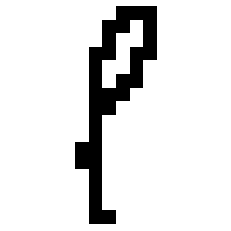

In [72]:
image1 = Xtest[5100]
image1 = image1.reshape(16, 16)
plt.imshow(-image1, cmap='gray')
plt.axis('off');

Okay. This makes sense. Due to the loop at the top part the drawn letter this ‘l’ looks very similar to ‘p’. Hence, our model incorrectly predicts this hand-drawn ‘l’ as the letter ‘p’. 

Let us consider the second row. The actual class is ‘f’ while our prediction shows it is ‘d’. Let us take a look at the actual letter from the `Xtest`

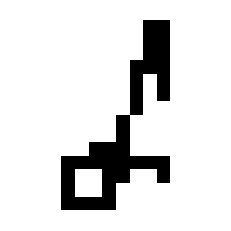

In [73]:
image2 = Xtest[2836]
image2 = image2.reshape(16, 16)
plt.imshow(-image2, cmap='gray')
plt.axis('off');

This looks very similar to the letter ‘d’. It looks more similar to ‘d’ than to ‘f’. If the labels were not mentioned, it would be hard to classify this hand-drawn letter as ‘f’. For what it looks like, our model has correctly tried to predict the letter.

Let us consider the third row. The actual class is ‘r’ while our prediction shows it is ‘z’. Let us take a look at the actual letter from the `Xtest`

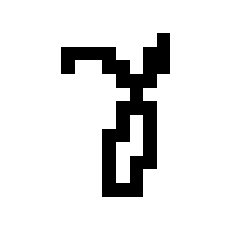

In [80]:
image3 = Xtest[8372]
image3 = image3.reshape(16, 16)
plt.imshow(-image3, cmap='gray')
plt.axis('off');

It is quite hard to understand why our model predicted this hand-drawn ‘r’ as ‘z’. Maybe the top part resembles a little like ‘z’ but still it is hard to understand this prediction.

Let us consider the fourth row. The actual class is ‘x’ while our prediction shows it is ‘t’. Let us take a look at the actual letter from the `Xtest`

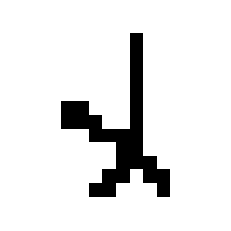

In [81]:
image4 = Xtest[9940]
image4 = image4.reshape(16, 16)
plt.imshow(-image4, cmap='gray')
plt.axis('off');

It is understandable why this prediction must be wrong. The vertical line curves at the very end similar to ‘t’. The horizontal line of ‘t’ can be seen on the left part. The presence of the long vertical line in the middle might be ruining the prediction for ‘x’. 

Let us consider the fifth row. The actual class is ‘v’ while our prediction shows it is ‘j’. Let us take a look at the actual letter from the `Xtest`

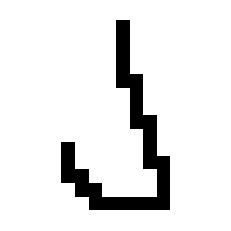

In [82]:
image5 = Xtest[9639]
image5 = image5.reshape(16, 16)
plt.imshow(-image5, cmap='gray')
plt.axis('off');

This looks very similar to the letter ‘j’ and hardly looks anything like ‘v’. The curves of ‘j’ have been accurately represented in this hand-drawn ‘v’. Hence, our model predicts this as ‘j’ and not ‘v’.

These are some of the wrongly predicted classes by our trained model. The reasonings for wrong predictions are also somewhat acceptable. Most of the time the letters drawn do not resemble like their actual class but a look a lot like a different class which are in fact correctly predicted.

To better understand these predictions, let us use confusion matrix.

In [26]:
pd.set_option('max_columns', None)
conf = confusion_matrix(Y_classes, Ttest)
colorful_conf = conf.style.background_gradient(cmap='Blues').format("{:.1f} %")

In [27]:
colorful_conf
#For some reason the colors disappear when closing and reopening the notebook

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
a,82.6 %,0.1 %,0.4 %,1.1 %,3.1 %,0.1 %,0.4 %,0.1 %,0.1 %,0.0 %,0.7 %,0.0 %,0.9 %,5.0 %,2.2 %,0.0 %,0.5 %,0.1 %,0.2 %,0.1 %,1.0 %,0.0 %,0.6 %,0.2 %,0.1 %,0.1 %
b,1.6 %,88.7 %,0.0 %,0.8 %,0.4 %,0.0 %,1.2 %,2.3 %,0.0 %,0.0 %,2.0 %,0.0 %,0.4 %,0.4 %,0.8 %,0.4 %,0.0 %,0.4 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.8 %
c,1.9 %,0.0 %,91.0 %,0.0 %,3.1 %,0.2 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.9 %,0.0 %,0.0 %,1.7 %,0.0 %,0.0 %,0.7 %,0.2 %,0.0 %,0.0 %,0.0 %,0.2 %,0.0 %,0.0 %,0.0 %
d,5.2 %,3.5 %,0.0 %,79.5 %,0.3 %,0.0 %,1.4 %,1.0 %,0.0 %,1.4 %,1.0 %,0.0 %,0.0 %,0.3 %,4.2 %,0.7 %,0.0 %,0.3 %,0.0 %,0.7 %,0.0 %,0.0 %,0.0 %,0.0 %,0.3 %,0.0 %
e,0.3 %,0.0 %,1.4 %,0.0 %,93.4 %,0.0 %,0.4 %,0.0 %,0.0 %,0.0 %,0.5 %,0.0 %,0.2 %,0.5 %,0.7 %,1.0 %,0.1 %,0.2 %,0.1 %,0.4 %,0.4 %,0.0 %,0.0 %,0.0 %,0.0 %,0.3 %
f,0.0 %,0.0 %,0.0 %,0.5 %,1.1 %,77.2 %,1.1 %,0.5 %,0.0 %,0.0 %,0.5 %,0.5 %,0.0 %,0.0 %,0.0 %,1.6 %,0.0 %,7.6 %,3.3 %,6.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %
g,2.8 %,0.6 %,0.2 %,0.4 %,1.6 %,0.0 %,79.4 %,0.2 %,0.4 %,1.0 %,0.0 %,0.2 %,0.2 %,0.4 %,0.4 %,0.6 %,3.6 %,1.4 %,4.5 %,0.0 %,0.2 %,0.0 %,0.0 %,0.0 %,1.6 %,0.2 %
h,0.0 %,3.5 %,0.0 %,1.7 %,0.0 %,0.6 %,0.0 %,79.7 %,0.0 %,0.0 %,4.7 %,0.6 %,0.6 %,7.6 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,1.2 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %
i,0.4 %,0.1 %,0.2 %,0.0 %,0.2 %,0.4 %,0.1 %,0.1 %,87.9 %,0.0 %,0.0 %,9.1 %,0.0 %,0.0 %,0.0 %,0.1 %,0.0 %,0.9 %,0.2 %,0.1 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.2 %
j,0.0 %,0.0 %,0.0 %,2.7 %,0.0 %,0.0 %,5.4 %,0.0 %,5.4 %,70.3 %,0.0 %,5.4 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,8.1 %,0.0 %,2.7 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %


From the confusion matrix we can see that our model predicts the correct class for the most part. However, there are instances where our model predicts incorrectly. These instances are very few but still interesting to look at. Like the letter ‘i’ which is very close to ‘j’ without the curved part at the bottom or the letters ‘i’ and ‘l’ which are again very similar without the dot on top. The model also confuses ‘f’ with ‘r’ which are similar without the horizontal line in the middle. Letters ‘f’ and ‘t’ are also confused few times. These look very similar too without the curves at the top and at the bottom. Another set of confused letters is ‘q’ and ‘g’. Without the curve at the bottom ‘q’ looks very similar to ‘g’. ‘g’ is also confused with ‘y’ whose bottom parts are similar to each other. ‘v’ and ‘u’ are also confusing the model as they are very much alike. 

## Conclusions

In conclusion, the experiments were successfully performed, and the best model trained with the hyperparameters using Convolutional Neural Network algorithm gave around 85% accuracy on the test data. Training this model took around 2 seconds which is actually very fast. The falsely predicted classes were also justified with acceptable reasoning.

Through this project, I learned that the prediction difficulty increases as the number of classes increase in the dataset and experimenting with multiple values for each of the hyperparameters greatly helps in finding that ‘best’ set of parameters that will give high accuracy for prediction. One hurdle that I stumbled upon was the ‘CUDA is out of memory error’ while running all experiments in one go. Hence, these experiments had to be categorized to run them without getting the error. Nevertheless, the experiments were performed successfully within sufficient amount of time.